In [1]:
import os
backend = 'pytorch'
os.environ['DGLBACKEND'] = backend

In [2]:
import torch
import dgl
import networkx as nx
import tqdm.auto as tqdm
import pickle
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import dgl.nn

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

Using backend: pytorch


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [66]:
class Net(nn.Module):
    def __init__(self, in_size, out_size, hidden_size, n_hidden=1, n_heads=1):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        
        msg_layers = [
            dgl.nn.GATConv(in_size, hidden_size, num_heads=self.n_heads),
            nn.Dropout(p=0.1)
        ]
        for _ in range(n_hidden - 1):
            msg_layers += [
                dgl.nn.GATConv(hidden_size*self.n_heads, hidden_size, num_heads=self.n_heads),
                nn.Dropout(p=0.1),
            ]

        self.msg_layers = nn.ModuleList(msg_layers)
        
        self.output_layer = nn.Linear(hidden_size*self.n_heads, out_size)
    
    def forward(self, g, h):
        for l in self.msg_layers:
            if isinstance(l, nn.Dropout):
                h = l(h)
            else:
                h = F.leaky_relu(l(g, h))
                h = h.view((-1, self.hidden_size*self.n_heads))
            
        h = F.leaky_relu(self.output_layer(h))
        
        return h

In [5]:
dgl_graphs, _ = dgl.data.utils.load_graphs(f'../data/dgl_graphs_{backend}.bin')
dgl_graphs = [g.to(device) for g in dgl_graphs]
nx_graphs = nx.read_gpickle(f'../data/nx_graphs_{backend}.pkl')

dataset = list(zip(dgl_graphs, nx_graphs))

train_set, test_set = train_test_split(dataset, train_size=0.7, shuffle=True)
train_set, val_set = train_test_split(train_set, train_size=0.7, shuffle=True)

In [6]:
train_set, _ = zip(*train_set)
val_set, _ = zip(*val_set)

In [67]:
stuck = True
retries = 0
while stuck and retries < 200:
    retries += 1
    
    net = Net(18, 2, 64, n_hidden=3, n_heads=4)
    if torch.cuda.is_available():
        net = net.cuda()

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    # because we only want to send w to GPU once
    y = train_set[0].ndata['y']
    pos_weight = len(y)/y.sum() - 1
    w = torch.FloatTensor([1, pos_weight]).to(device)

    criterion = torch.nn.CrossEntropyLoss(weight=w)

    batch_size = 32
    n_epochs = 200

    data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=dgl.batch)

    writer = SummaryWriter()

    pbar = tqdm.trange(n_epochs)
    for epoch in pbar:
        net.train()

        epoch_loss = 0
        for batch_i, batch in enumerate(data_loader):
            x = batch.ndata['x']
            y = batch.ndata['y']

    #         pos_weight = len(y)/y.sum() - 1
    #         w = torch.FloatTensor([1, pos_weight]).to(device)

            optimizer.zero_grad()
            y_pred = net(batch, x)
            loss = criterion(y_pred, y.squeeze())
            loss.backward()
            optimizer.step()

            epoch_loss += loss.detach().item()

        epoch_loss /= (batch_i + 1)
        writer.add_scalar("Loss/train", epoch_loss, epoch)

        with torch.no_grad():
            net.eval()
            batch = dgl.batch(val_set)

            x = batch.ndata['x']
            y = batch.ndata['y']

    #         pos_weight = len(y)/y.sum() - 1
    #         w = torch.FloatTensor([1, pos_weight]).to(device)

            y_pred = net(batch, x)
            val_loss = criterion(y_pred, y.squeeze())
            writer.add_scalar("Loss/validation", val_loss, epoch)

#         if epoch >= 15 and epoch_loss > 0.65:
        if False:
            pbar.close()
            stuck = True
            break
        else:
            stuck = False

        pbar.set_postfix({
            'Train Loss': '{:.4f}'.format(epoch_loss),
            'Validation Loss': '{:.4f}'.format(val_loss),
        })

        writer.flush()

    writer.close()

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [58]:
dgl_g, nx_g = test_set[0]

In [59]:
x = dgl_g.ndata['x']
y = dgl_g.ndata['y']
idx2edge = dgl_g.ndata['e']

In [60]:
with torch.no_grad():
    y_pred = net(dgl_g, x)
    y_prob = F.softmax(y_pred, dim=1)

    for e, p in zip(idx2edge.cpu().numpy(), y_prob.cpu().numpy()):
        nx_g.edges[e]['p_in_solution'] = p[1]

in_solution = nx.get_edge_attributes(nx_g, 'in_solution')
in_greedy_solution = nx.get_edge_attributes(nx_g, 'in_greedy_solution')
p_in_solution = nx.get_edge_attributes(nx_g, 'p_in_solution')

In [61]:
cmap_colors = np.zeros((100, 4))
cmap_colors[:, 0] = 1
cmap_colors[:, 3] = np.linspace(0, 1, 100)
cmap = ListedColormap(cmap_colors)

Text(0.5, 1.0, 'Output')

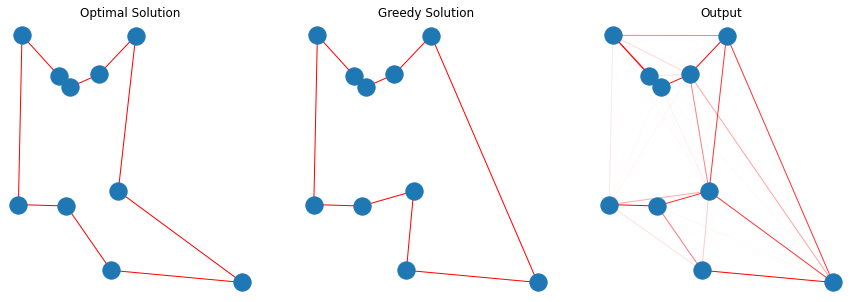

In [62]:
pos = {n: (nx_g.nodes[n]['x'], nx_g.nodes[n]['y']) for n in nx_g.nodes}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

nx.draw(nx_g, pos, edge_color=in_solution.values(), edge_cmap=cmap, ax=ax[0], edge_vmax=1, edge_vmin=0)
nx.draw(nx_g, pos, edge_color=in_greedy_solution.values(), edge_cmap=cmap, ax=ax[1], edge_vmax=1, edge_vmin=0)
nx.draw(nx_g, pos, edge_color=p_in_solution.values(), edge_cmap=cmap, ax=ax[2], edge_vmax=1, edge_vmin=0)
ax[0].set_title('Optimal Solution')
ax[1].set_title('Greedy Solution')
ax[2].set_title('Output')

In [24]:
# torch.save(net.state_dict(), 'net_Jan23_23-28-23_VEGA.bin')